# Reinforcement learning velocity control environment

In [1]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import HTML
from matplotlib import animation
import matplotlib.pyplot as plt
from collections import deque
from gym import Env, spaces
import numpy as np
import graphviz
import random
import keras
import math
import cv2
import io

### Environment

In [2]:
class TC_environment(Env):
    def __init__(self):
        self.observations = 4
        self.max_step_size = 4
        self.deltaT = 3
        self.width = 100
        self.hight = 100
        self.episode_path = []
        self.car_init_pos = -self.hight/2 
        self.car_init_vel = 1
        self.car_state = [self.car_init_pos, self.car_init_vel]
        self.action_space = spaces.Discrete(2) # A = {v+, v-}

    def reset(self):
        increments = []
        self.car_state[0] = self.car_init_pos
        self.car_state[1] = self.car_init_vel 
        step_size = random.uniform(2, self.max_step_size)
        x_random = random.uniform(-self.width/4, self.width/4)
        y_random = self.hight/2
            
        init_pos = (x_random, y_random)
        self.episode_path = []
        self.episode_path.append(init_pos)
        theta = random.uniform(4.45059, 4.97419)
        for i in range(0,self.observations):
            increments.append((step_size*round(np.cos(theta)), step_size*round(np.sin(theta))))

        for i in range(0,self.observations-1):
            listp = []
            listp.append(self.episode_path[i])
            listp.append(increments[i])
            self.episode_path.append(tuple([sum(tup) for tup in zip(*listp)]))

        return self.episode_path

    def select_action(self, action):
        if (action == 0):
            self.car_state[1] += 0.1
        if (action == 1):
            self.car_state[1] -= 0.1
        
    def step(self, action):
        A = self.episode_path[3][1] - self.episode_path[0][1]
        B = self.episode_path[3][0] - self.episode_path[0][0]
        x_new_increment = B/(self.observations-1)
        y_new_increment = A/(self.observations-1)
        new_init_pos = (self.episode_path[3][0] + x_new_increment, self.episode_path[3][1] + y_new_increment)
        increments = []
        new_episode_path = []
        new_episode_path.append(new_init_pos)
        for i in range(0,self.observations-1):
            increments.append((x_new_increment, y_new_increment))

        for i in range(0,self.observations-1):
            listp = []
            listp.append(new_episode_path[i])
            listp.append(increments[i])
            new_episode_path.append(tuple([sum(tup) for tup in zip(*listp)]))
            
        self.episode_path = new_episode_path
        distance = np.sqrt(new_episode_path[3][0]**2 + (new_episode_path[3][1] - self.car_state[0])**2)
        self.select_action(action)
        self.car_state[0] = self.car_state[0] + self.car_state[1]*self.deltaT
        reward = 1/distance
        done = False
        if (distance <= 20) or (self.car_state[0] > self.hight/2) or (self.car_state[0] < -self.hight/2):
          done = True
        return new_episode_path, reward, done
    
    def getImage(self,path):
        return OffsetImage(plt.imread(path, format="png"), zoom=0.15)   

    def getFig_toArray(self, fig, dpi=250):
        buf = io.BytesIO()
        fig.savefig(buf, format="png", dpi=dpi)
        buf.seek(0)
        img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        buf.close()
        img = cv2.imdecode(img_arr, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    def custom_render(self, path):
        fig, ax = plt.subplots()
        fig.subplots_adjust(0,0,1,1)
        ax.axis('off')
        margin = 10
        plt.plot([0,0], [-100,100], linestyle='--', linewidth=1, color='black')
        plt.axvline(x= self.width/4, c="black")
        plt.axvline(x=-self.width/4, c="black")
        plt.xlim([-self.width/2 -margin, self.width/2 +margin])
        plt.ylim([-self.hight/2 -margin, self.hight/2 +margin])
        plt.rcParams["figure.figsize"] = (5,5)
        car = AnnotationBbox( self.getImage('https://github.com/JHermosillaD/Reinforcement_learning/blob/main/environment_simulator_V1/imgs/car.png?raw=true'), (0, self.car_state[0] ), frameon=False)
        ax.add_artist(car)
        equis = []
        yes = []
        for i in path:
            pedestrian = AnnotationBbox( self.getImage('https://github.com/JHermosillaD/Reinforcement_learning/blob/main/environment_simulator_V1/imgs/pedestrian.png?raw=true'), i , frameon=False)
            equis.append(i[0])
            yes.append(i[1])
            ax.add_artist(pedestrian)
        plt.plot(equis, yes, linestyle='--', linewidth=1, color='black')
        plot_array = self.getFig_toArray(fig)
        plt.close()
        return plot_array

### Deep Q-learning

#### Plot network

In [3]:
def plot_DQN(model):
    input_layer = 0;
    hidden_layers_nr = 0;
    layer_types = [];
    hidden_layers = [];
    output_layer = 0;

    for layer in model.layers:
        if(layer == model.layers[0]):
            input_layer = int(str(layer.input_shape).split(",")[1][1:-1]);
            hidden_layers_nr += 1;
            if (type(layer) == keras.layers.core.Dense):
                hidden_layers.append(int(str(layer.output_shape).split(",")[1][1:-1]));
                layer_types.append("Dense");
            else:
                hidden_layers.append(1);
        else:
            if(layer == model.layers[-1]):
                output_layer = int(str(layer.output_shape).split(",")[1][1:-1]);
            else:
                hidden_layers_nr += 1;
                if (type(layer) == keras.layers.core.Dense):
                    hidden_layers.append(int(str(layer.output_shape).split(",")[1][1:-1]));
                    layer_types.append("Dense");
                else:
                    hidden_layers.append(1);

        last_layer_nodes = input_layer;
        nodes_up = input_layer;
        if(type(model.layers[0]) != keras.layers.core.Dense):
            last_layer_nodes = 1;
            nodes_up = 1;
            input_layer = 1;

        g = graphviz.Digraph('g');
        n = 0;
        g.graph_attr.update(splines="line", nodesep='0.5', ranksep='4.0', rankdir='TB', size="15", fontsize='35pt');
        with g.subgraph(name='cluster_input') as c:
            if(type(model.layers[0]) == keras.layers.core.Dense):
                the_label = 'Input states';
                c.attr(color='white')
                for i in range(0, input_layer):
                    n += 1;
                    c.node(str(n));
                    c.attr(label=the_label, rank='same');
                    c.node_attr.update(color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle");
            else:
                raise ValueError("ANN Visualizer: Layer not supported for visualizing");
        for i in range(0, hidden_layers_nr):
            with g.subgraph(name="cluster_"+str(i+1)) as c:
                if (layer_types[i] == "Dense"):
                    c.attr(color='white', rank='same', labeljust="right", labelloc="c");
                    for j in range(0, hidden_layers[i]):
                        n += 1;
                        c.node(str(n), shape="circle", style="filled", color="#3498db", fontcolor="#3498db");
                        for h in range(nodes_up - last_layer_nodes + 1 , nodes_up + 1):
                            g.edge(str(h), str(n));
                    last_layer_nodes = hidden_layers[i];
                    nodes_up += hidden_layers[i];

        with g.subgraph(name='cluster_output') as c:
            if (type(model.layers[-1]) == keras.layers.core.Dense):
                c.attr(color='white', rank='same', labeljust="1");
                for i in range(1, output_layer+1):
                    n += 1;
                    c.node(str(n), shape="circle", style="filled", color="#e74c3c", fontcolor="#e74c3c");
                    for h in range(nodes_up - last_layer_nodes + 1 , nodes_up + 1):
                        g.edge(str(h), str(n));
                c.attr(label='Action states', labelloc="b")
                c.node_attr.update(color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle");

        g.attr(arrowShape="none");
        g.edge_attr.update(arrowhead='none', color="#707070", penwidth='0.5');
    return g

#### Model

In [4]:
class DQN:
    def __init__(self, env, hidden_size=16):
        self.state_size = 8
        self.action_size = env.action_space.n
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(hidden_size, activation="relu", input_dim=self.state_size))
        self.model.add(keras.layers.Dense(hidden_size, activation="relu"))
        self.model.add(keras.layers.Dense(self.action_size, activation="linear"))
        self.model.compile(loss="mse", optimizer="Adam")

    def __call__(self,s):
        s = np.reshape(s, [1, self.state_size])
        a = self.model.predict(s)
        a = np.reshape(a,[self.action_size])
        return a

#### Replay memory buffer

In [5]:
class Memory:
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(len(self.buffer),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [6]:
def create_experience(Q,replaybuffer,eps=0.1,max_episodes=1000):
    average_return = 0
    for i in range(max_episodes):
        done = False
        state = env.reset()
        while not done:
            average_return += 1
            if eps>np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(Q(state))
            next_state, reward, done = env.step(action)
            replaybuffer.add((state,action,reward,next_state,done))
            state = next_state
    avg_return = average_return/max_episodes
    return avg_return

#### Epsilon-greedy approach

In [7]:
def eps_decay(i, start=1.0, stop=0.01, annealing_stop=1000):
    inew = min(i,annealing_stop)
    return (start * (annealing_stop - inew) + stop * inew) / annealing_stop

### DQN initialization

In [8]:
env = TC_environment()
Q = DQN(env,hidden_size=32)

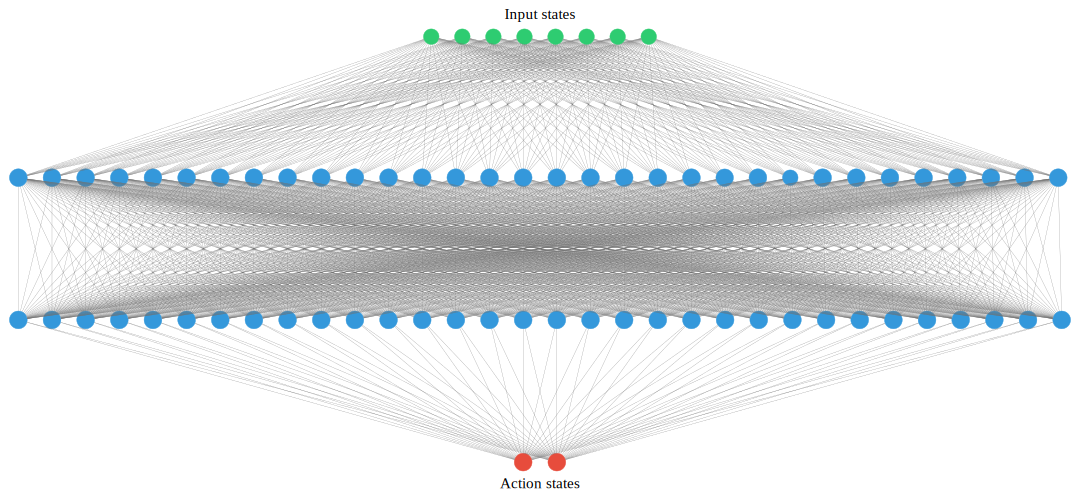

In [9]:
plot_DQN(Q.model)

### Environment simulation

In [19]:
def env_simulation(env):
    fig, ax = plt.subplots()
    fig.subplots_adjust(0,0,1,1)
    ax.axis('off')
    state = env.reset()
    episode = []
    max_steps = 10
    for n_episode in range(max_steps):
        im = ax.imshow(env.custom_render(state), aspect='auto')
        episode.append([im])
        action = env.action_space.sample()
        new_state, reward, done = env.step(action)
        state = new_state
    plt.close()
    return fig, episode

In [20]:
fig, episode = env_simulation(env)
experiment = animation.ArtistAnimation(fig, episode, interval=500, repeat=30, blit=True)
HTML(experiment.to_html5_video())

In [13]:
state = env.reset()
flat_state = list(sum(state, ()))

In [14]:
TargetQ = DQN(env,hidden_size=32)
TargetQ.model.set_weights(Q.model.get_weights())

In [18]:
train_episodes = 5
gamma = 0.99       
explore_start = 0.9
explore_stop = 0.01
annealing_stop = train_episodes/4 
hidden_size = 16            
batch_size = 32         

replaybuffer = Memory()
create_experience(Q,replaybuffer,eps=1.0,max_episodes=1000)

learning_curve=[] 
for ep in range(1,train_episodes+1):
    state = env.reset()
    flat_state = list(sum(state, ()))
    eps = eps_decay(ep,explore_start,explore_stop,annealing_stop)
    total_return = 0 
    done = False
    while not done: 
        if eps>np.random.rand():
            action = env.action_space.sample()
        else:
            action = np.argmax(Q(flat_state))
        next_state, reward, done = env.step(action)
        flat_next_state = list(sum(next_state, ()))
        total_return += reward
        replaybuffer.add((state,action,reward,flat_next_state,done))
        flat_state = flat_next_state 
        
        inputs = np.zeros((batch_size, 8))
        targets = np.zeros((batch_size, env.action_space.n))
        minibatch = replaybuffer.sample(batch_size)
        for i, (state_b, action_b, reward_b, next_state_b, done_b) in enumerate(minibatch):
            inputs[i:i+1] = state_b
            if done_b:
                target = reward_b
            else:
                target = reward_b + gamma * np.amax(TargetQ(next_state_b)) 
            targets[i] = Q(state_b)
            targets[i][action_b] = target
        Q.model.fit(inputs, targets, epochs=1, verbose=0)
    if ep%10==0:
        print("Episode ",ep, "average return = ", total_return, "eps =",eps)
        TargetQ.model.set_weights(Q.model.get_weights()) 
    learning_curve.append(total_return)
plt.plot(learning_curve)

1/1 [==============================] - 0s 17ms/step


ValueError: ignored